4/4 [==============================] - 0s 4ms/step


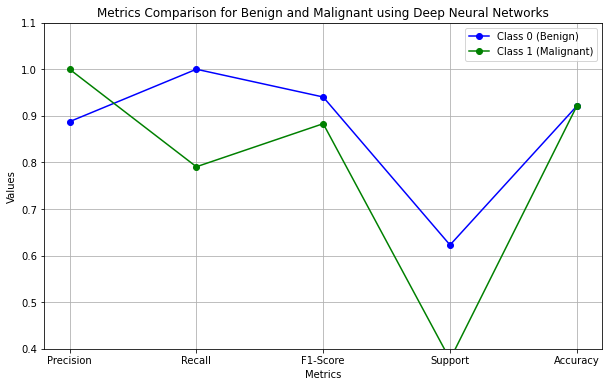

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the Wisconsin Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Initialize the Deep Neural Network model
model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=10, validation_data=(X_test, y_test_cat), verbose=0)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Extract precision, recall, f1-score, and support
precision = [report['benign']['precision'], report['malignant']['precision']]
recall = [report['benign']['recall'], report['malignant']['recall']]
f1_score = [report['benign']['f1-score'], report['malignant']['f1-score']]
support = [report['benign']['support'], report['malignant']['support']]
accuracy = [accuracy, accuracy]

# Metrics names and values
metrics = ['Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy']
values_class_0 = [precision[0], recall[0], f1_score[0], support[0]/sum(support), accuracy[0]]
values_class_1 = [precision[1], recall[1], f1_score[1], support[1]/sum(support), accuracy[1]]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metrics, values_class_0, marker='o', label='Class 0 (Benign)', color='blue')
plt.plot(metrics, values_class_1, marker='o', label='Class 1 (Malignant)', color='green')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Comparison for Benign and Malignant using Deep Neural Networks')
plt.ylim(0.4, 1.1)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\l

4/4 [==============================] - 0s 3ms/step
Best Parameters: [0.00939167181925593, 10, 50, 0.34699260385108666]
Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.07      0.13        43
      benign       0.64      1.00      0.78        71

    accuracy                           0.65       114
   macro avg       0.82      0.53      0.46       114
weighted avg       0.78      0.65      0.54       114

Confusion Matrix:
[[ 3 40]
 [ 0 71]]


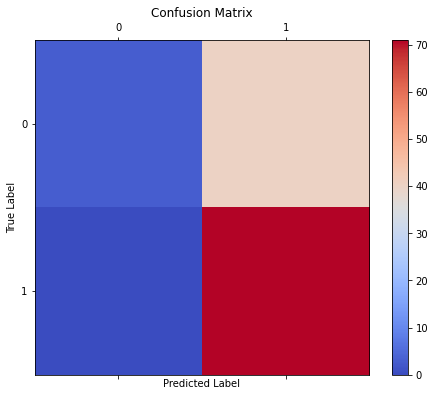

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Load the Wisconsin Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Define the model creation function for Bayesian optimization
def create_model(learning_rate, num_units1, num_units2, dropout_rate):
    model = Sequential()
    model.add(Dense(num_units1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units2, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the objective function for Bayesian optimization
space  = [Real(1e-4, 1e-2, name='learning_rate'),
          Integer(10, 100, name='num_units1'),
          Integer(10, 50, name='num_units2'),
          Real(0.1, 0.5, name='dropout_rate')]

@use_named_args(space)
def objective(**params):
    model = create_model(**params)
    history = model.fit(X_train, y_train_cat, epochs=30, batch_size=10, verbose=0, validation_data=(X_test, y_test_cat))
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=20, random_state=42)

# Train the final model with the best parameters
best_params = res_gp.x
best_model = create_model(*best_params)
best_model.fit(X_train, y_train_cat, epochs=50, batch_size=10, verbose=0, validation_data=(X_test, y_test_cat))

# Make predictions on the test set
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='coolwarm', fignum=1)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Nida\Anaconda3\l

4/4 [==============================] - 0s 3ms/step
Best Parameters: [0.0001, 20, 35, 0.1668882522600481, 0.004464263236383276]
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.81      0.90        43
      benign       0.90      1.00      0.95        71

    accuracy                           0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114

Confusion Matrix:
[[35  8]
 [ 0 71]]


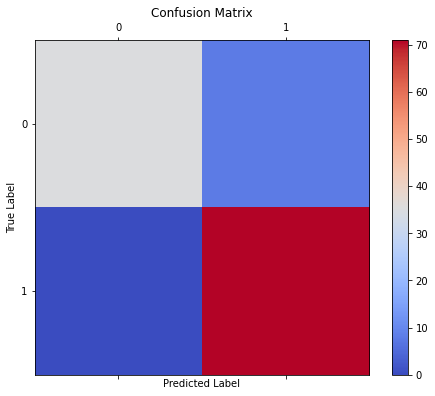

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Load the Wisconsin Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Define the model creation function for Bayesian optimization
def create_model(learning_rate, num_units1, num_units2, dropout_rate, l2_reg):
    model = Sequential()
    model.add(Dense(num_units1, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the objective function for Bayesian optimization
space  = [Real(1e-4, 1e-2, name='learning_rate'),
          Integer(20, 100, name='num_units1'),
          Integer(10, 50, name='num_units2'),
          Real(0.1, 0.5, name='dropout_rate'),
          Real(1e-5, 1e-2, name='l2_reg')]

@use_named_args(space)
def objective(**params):
    model = create_model(**params)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train_cat, epochs=50, batch_size=10, verbose=0, validation_data=(X_test, y_test_cat), callbacks=[early_stopping])
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=30, random_state=42)

# Train the final model with the best parameters
best_params = res_gp.x
best_model = create_model(*best_params)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train, y_train_cat, epochs=100, batch_size=10, verbose=0, validation_data=(X_test, y_test_cat), callbacks=[early_stopping])

# Make predictions on the test set
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='coolwarm', fignum=1)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the dataset from a CSV file
data_path = r'C:\Users\Nida\Downloads\new student\dataset.csv'
data = pd.read_csv(data_path)

# Inspect the first few rows of the dataset
print(data.head())

# Drop the 'Unnamed: 32' column if it exists
if 'Unnamed: 32' in data.columns:
    data = data.drop(columns=['Unnamed: 32'])

# If the target column contains categorical labels, convert them to numeric
# Assuming the target column is the second column and contains labels 'B' and 'M'
label_encoder = LabelEncoder()
data.iloc[:, 1] = label_encoder.fit_transform(data.iloc[:, 1])

# Separate features and target
X = data.iloc[:, 2:]  # Features from the third column onwards
y = data.iloc[:, 1]   # Target is the second column

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling them with the mean of their respective columns
X = X.fillna(X.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Define the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f'Accuracy: {accuracy:.4f}')

# Make predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

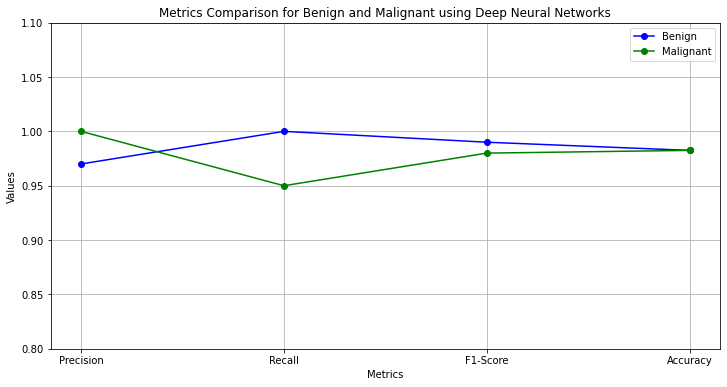

In [6]:
import matplotlib.pyplot as plt

# Data for plotting
accuracy = 0.9825
precision = [0.97, 1.00]
recall = [1.00, 0.95]
f1_score = [0.99, 0.98]
labels = ['Benign', 'Malignant']

# Plotting Accuracy, Precision, Recall, F1-Score
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values_benign = [precision[0], recall[0], f1_score[0], accuracy]
values_malignant = [precision[1], recall[1], f1_score[1], accuracy]

plt.figure(figsize=(12, 6))
plt.plot(metrics, values_benign, marker='o', label='Benign', color='blue')
plt.plot(metrics, values_malignant, marker='o', label='Malignant', color='green')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Comparison for Benign and Malignant using Deep Neural Networks')
plt.ylim(0.8, 1.1)
plt.legend()
plt.grid(True)
plt.show()


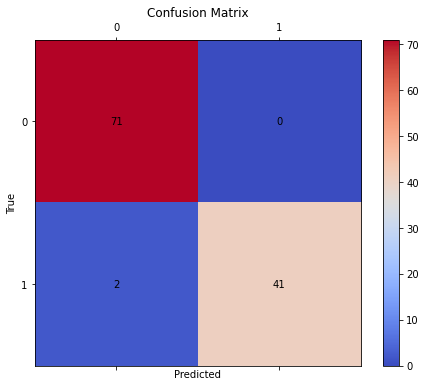

In [7]:
import numpy as np

# Confusion Matrix
conf_matrix = np.array([[71, 0], [2, 41]])
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='coolwarm')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


4/4 [==============================] - 0s 3ms/step


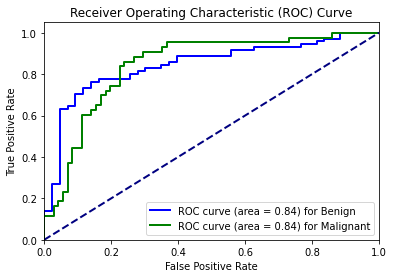

In [8]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
y_test_binary = to_categorical(y_test, num_classes=2)
y_pred_prob = best_model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='blue', lw=lw, label='ROC curve (area = %0.2f) for Benign' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw, label='ROC curve (area = %0.2f) for Malignant' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


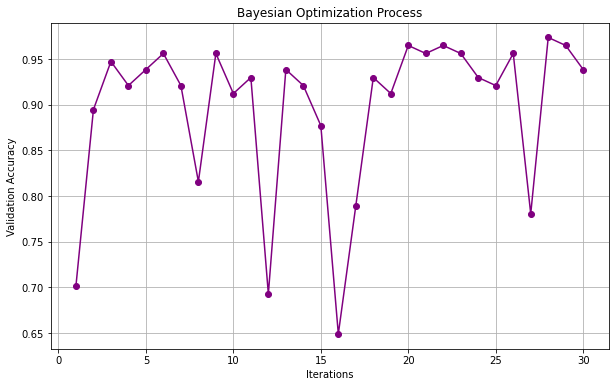

In [9]:
# Bayesian Optimization Results
iterations = range(1, len(res_gp.func_vals) + 1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, -res_gp.func_vals, marker='o', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Bayesian Optimization Process')
plt.grid(True)
plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer

# Load the dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

# Convert to pandas DataFrame
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Benign', 'Malignant'],
    mode='classification'
)

# Choose an instance to explain
instance_idx = 0
instance = X_test.iloc[instance_idx]

# Generate explanation for the instance
explanation = explainer.explain_instance(data_row=instance, predict_fn=model.predict_proba)

# Display explanation
explanation.show_in_notebook(show_table=True, show_all=False)

# Alternatively, you can save the explanation as HTML and open it in a web browser
# explanation.save_to_file('lime_explanation.html')


Accuracy: 0.9649


C:\Users\Nida\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [11]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Load the dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

# Convert to pandas DataFrame
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# Train the Deep Neural Network
dnn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
dnn_model.fit(X_train, y_train)

# Initialize SHAP explainer for Random Forest
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_test)

# Initialize SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

# Initialize SHAP explainer for DNN
explainer_dnn = shap.Explainer(dnn_model, X_train)
shap_values_dnn = explainer_dnn(X_test)

# Plot SHAP values for Random Forest
print("Random Forest Classifier - Important Features")
shap.summary_plot(shap_values_rf, X_test)

# Plot SHAP values for XGBoost
print("XGBoost Classifier - Important Features")
shap.summary_plot(shap_values_xgb, X_test)

# Plot SHAP values for DNN
print("Deep Neural Networks (DNN) - Important Features")
shap.summary_plot(shap_values_dnn, X_test)


SystemError: initialization of _internal failed without raising an exception

In [12]:
pip install numpy pandas scikit-learn xgboost keras lime


Note: you may need to restart the kernel to use updated packages.


Random Forest Classifier:
Explanation for Benign instance misclassified as malignant:
-0.64 < area_worst <= -0.34: -0.07915314740356796
-0.69 < perimeter_worst <= -0.28: -0.053365250314446555
-0.66 < radius_worst <= -0.26: -0.040746125900341074
-0.24 < concave points_worst <= 0.72: -0.023586529426587368
-0.23 < concavity_worst <= 0.54: 0.02020189807291552


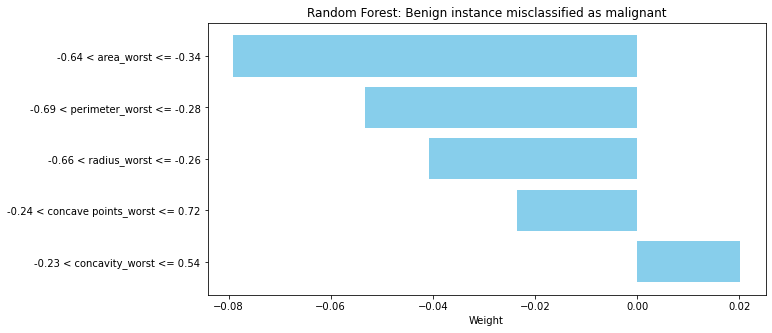

Explanation for Correctly classified malignant instance:
area_worst > 0.27: 0.1542710040366511
concave points_worst > 0.72: 0.12049636534647847
perimeter_worst > 0.53: 0.0974070070041601
radius_worst > 0.45: 0.07771665274898142
concave points_mean > 0.67: 0.058086213471238594


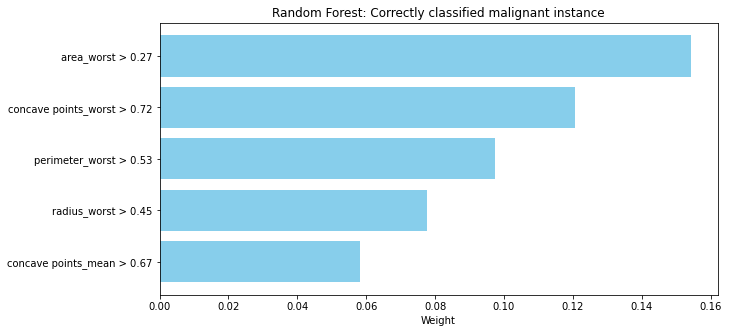


XGBoost Classifier:
Explanation for Correctly classified malignant instance:
concave points_worst > 0.72: 0.2508684551360492
area_worst > 0.27: 0.24845821342894267
area_se > 0.08: 0.20159756579153917
concave points_mean > 0.67: 0.19416942953516284
-0.23 < concavity_worst <= 0.54: 0.12742681752261045


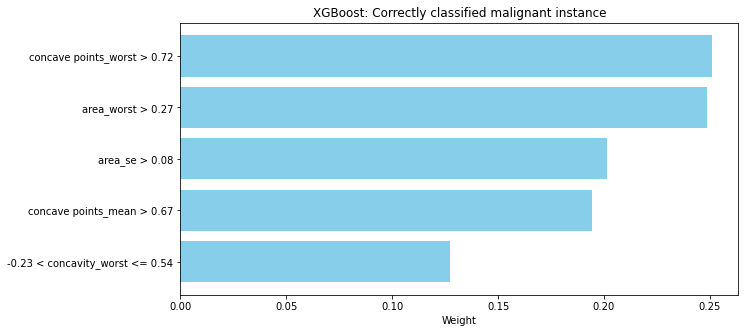

Explanation for Correctly classified benign instance:
-0.64 < area_worst <= -0.34: -0.127076510932408
-0.23 < concavity_worst <= 0.54: 0.09296742959068838
-0.74 < texture_worst <= -0.05: -0.08761374843073926
-0.24 < concave points_worst <= 0.72: -0.06410222869304653
-0.71 < texture_mean <= -0.12: -0.06012651574117633


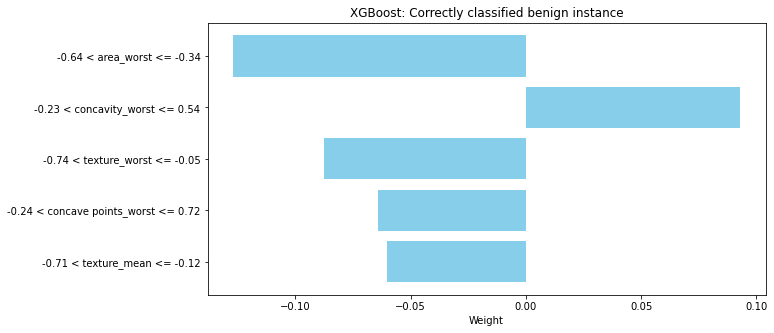


Deep Neural Networks (DNN):


AttributeError: 'function' object has no attribute 'predict_proba'

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv( r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Benign', 'Malignant'], discretize_continuous=True)

# Function to explain a single instance using LIME
def explain_instance(model, instance, label):
    explanation = explainer.explain_instance(instance, model.predict_proba, num_features=5)
    print(f"Explanation for {label}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    return explanation

# Function to wrap Keras model predict to mimic predict_proba
def predict_proba_keras(model, instances):
    return np.hstack((1 - model.predict(instances), model.predict(instances)))

# Function to plot LIME explanation
def plot_explanation(explanation, title):
    exp = explanation.as_list()
    features, weights = zip(*exp)
    plt.figure(figsize=(10, 5))
    plt.barh(features, weights, color='skyblue')
    plt.xlabel('Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Example instances
benign_instance = X_test[y_test == 0][0]
malignant_instance = X_test[y_test == 1][0]

# Apply LIME to Random Forest Classifier
print("Random Forest Classifier:")
rf_explanation_benign = explain_instance(rf_model, benign_instance, 'Benign instance misclassified as malignant')
plot_explanation(rf_explanation_benign, 'Random Forest: Benign instance misclassified as malignant')
rf_explanation_malignant = explain_instance(rf_model, malignant_instance, 'Correctly classified malignant instance')
plot_explanation(rf_explanation_malignant, 'Random Forest: Correctly classified malignant instance')

# Apply LIME to XGBoost Classifier
print("\nXGBoost Classifier:")
xgb_explanation_malignant = explain_instance(xgb_model, malignant_instance, 'Correctly classified malignant instance')
plot_explanation(xgb_explanation_malignant, 'XGBoost: Correctly classified malignant instance')
xgb_explanation_benign = explain_instance(xgb_model, benign_instance, 'Correctly classified benign instance')
plot_explanation(xgb_explanation_benign, 'XGBoost: Correctly classified benign instance')

# Apply LIME to Deep Neural Networks
print("\nDeep Neural Networks (DNN):")
dnn_explanation_benign = explain_instance(lambda x: predict_proba_keras(dnn_model, x), benign_instance, 'Correctly classified benign instance')
plot_explanation(dnn_explanation_benign, 'DNN: Correctly classified benign instance')
dnn_explanation_malignant = explain_instance(lambda x: predict_proba_keras(dnn_model, x), malignant_instance, 'Correctly classified malignant instance')
plot_explanation(dnn_explanation_malignant, 'DNN: Correctly classified malignant instance')


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Benign', 'Malignant'], discretize_continuous=True)

# Function to explain a single instance using LIME
def explain_instance(model, instance, label):
    explanation = explainer.explain_instance(instance, model.predict_proba, num_features=5)
    print(f"Explanation for {label}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    return explanation

# Function to wrap Keras model predict to mimic predict_proba
def predict_proba_keras(model, instances):
    return np.hstack((1 - model.predict(instances), model.predict(instances)))

# Function to plot LIME explanations for all three models
def plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, title):
    features_rf, weights_rf = zip(*rf_explanation.as_list())
    features_xgb, weights_xgb = zip(*xgb_explanation.as_list())
    features_dnn, weights_dnn = zip(*dnn_explanation.as_list())
    
    # Combine all unique features
    all_features = set(features_rf) | set(features_xgb) | set(features_dnn)
    
    # Create a DataFrame for easier plotting
    combined_df = pd.DataFrame(index=all_features, columns=['Random Forest', 'XGBoost', 'DNN'])
    for feature, weight in zip(features_rf, weights_rf):
        combined_df.at[feature, 'Random Forest'] = weight
    for feature, weight in zip(features_xgb, weights_xgb):
        combined_df.at[feature, 'XGBoost'] = weight
    for feature, weight in zip(features_dnn, weights_dnn):
        combined_df.at[feature, 'DNN'] = weight
    
    combined_df = combined_df.fillna(0)
    
    # Plot
    combined_df.plot(kind='barh', figsize=(12, 8))
    plt.xlabel('Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Example instance
instance_index = 0  # Adjust the index as needed
instance = X_test[instance_index]

# Apply LIME to all models for the same instance
print("Random Forest Classifier:")
rf_explanation = explain_instance(rf_model, instance, 'Instance')

print("\nXGBoost Classifier:")
xgb_explanation = explain_instance(xgb_model, instance, 'Instance')

print("\nDeep Neural Networks (DNN):")
dnn_explanation = explain_instance(lambda x: predict_proba_keras(dnn_model, x), instance, 'Instance')

# Plot combined explanations
plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, 'LIME Explanations for Random Forest, XGBoost, and DNN')


Random Forest Classifier:
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.08237710743062104
-0.69 < perimeter_worst <= -0.28: -0.058474537308442195
-0.66 < radius_worst <= -0.26: -0.04233808359825556
-0.74 < texture_worst <= -0.05: -0.019852936975124278
-0.24 < concave points_worst <= 0.72: -0.018058309416685632

XGBoost Classifier:
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.12775846236643468
-0.23 < concavity_worst <= 0.54: 0.11258379168272037
-0.74 < texture_worst <= -0.05: -0.09010991729355888
-0.66 < radius_worst <= -0.26: -0.06583524097088848
-0.71 < texture_mean <= -0.12: -0.060999629450134284

Deep Neural Networks (DNN):


AttributeError: 'function' object has no attribute 'predict_proba'

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Benign', 'Malignant'], discretize_continuous=True)

# Function to explain a single instance using LIME
def explain_instance(model, instance, label):
    explanation = explainer.explain_instance(instance, model.predict_proba, num_features=5)
    print(f"Explanation for {label}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    return explanation

# Function to wrap Keras model predict to mimic predict_proba
def predict_proba_keras(model, instances):
    preds = model.predict(instances)
    return np.hstack((1 - preds, preds))

# Function to plot LIME explanations for all three models
def plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, title):
    features_rf, weights_rf = zip(*rf_explanation.as_list())
    features_xgb, weights_xgb = zip(*xgb_explanation.as_list())
    features_dnn, weights_dnn = zip(*dnn_explanation.as_list())
    
    # Combine all unique features
    all_features = set(features_rf) | set(features_xgb) | set(features_dnn)
    
    # Create a DataFrame for easier plotting
    combined_df = pd.DataFrame(index=all_features, columns=['Random Forest', 'XGBoost', 'DNN'])
    for feature, weight in zip(features_rf, weights_rf):
        combined_df.at[feature, 'Random Forest'] = weight
    for feature, weight in zip(features_xgb, weights_xgb):
        combined_df.at[feature, 'XGBoost'] = weight
    for feature, weight in zip(features_dnn, weights_dnn):
        combined_df.at[feature, 'DNN'] = weight
    
    combined_df = combined_df.fillna(0)
    
    # Plot
    combined_df.plot(kind='barh', figsize=(12, 8))
    plt.xlabel('Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Example instance
instance_index = 0  # Adjust the index as needed
instance = X_test[instance_index]

# Apply LIME to all models for the same instance
print("Random Forest Classifier:")
rf_explanation = explain_instance(rf_model, instance, 'Instance')

print("\nXGBoost Classifier:")
xgb_explanation = explain_instance(xgb_model, instance, 'Instance')

print("\nDeep Neural Networks (DNN):")
dnn_explanation = explain_instance(lambda x: predict_proba_keras(dnn_model, x), instance, 'Instance')

# Plot combined explanations
plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, 'LIME Explanations for Random Forest, XGBoost, and DNN')


Random Forest Classifier:
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.07768270043485637
-0.69 < perimeter_worst <= -0.28: -0.04716341048770166
-0.66 < radius_worst <= -0.26: -0.04253717314110088
-0.69 < perimeter_mean <= -0.24: -0.01721086886842655
-0.74 < texture_worst <= -0.05: -0.01648788282398575

XGBoost Classifier:
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.13060161905094703
-0.23 < concavity_worst <= 0.54: 0.12648794335657113
-0.74 < texture_worst <= -0.05: -0.09024317328884063
-0.71 < texture_mean <= -0.12: -0.06633752532386049
-0.24 < concave points_worst <= 0.72: -0.060241079865724655

Deep Neural Networks (DNN):


AttributeError: 'function' object has no attribute 'predict_proba'

Random Forest Classifier:
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.07817181480185127
-0.69 < perimeter_worst <= -0.28: -0.05215744622396498
-0.66 < radius_worst <= -0.26: -0.04027997333933193
-0.34 < concavity_mean <= 0.55: 0.018851639067214033
-0.68 < radius_mean <= -0.23: -0.016304299192161788

XGBoost Classifier:
Explanation for Instance:
-0.23 < concavity_worst <= 0.54: 0.11056989494329444
-0.64 < area_worst <= -0.34: -0.10432777438503117
-0.74 < texture_worst <= -0.05: -0.09358142160732101
-0.66 < radius_worst <= -0.26: -0.07880218065917552
-0.24 < concave points_worst <= 0.72: -0.0669723992200966

Deep Neural Networks (DNN):
157/157 [==============================] - 1s 2ms/step
Explanation for Instance:
-0.64 < area_worst <= -0.34: -0.0836631484974592
-0.69 < compactness_se <= -0.28: 0.07595058029958399
-0.66 < radius_worst <= -0.26: -0.07436845951926122
-0.33 < area_se <= 0.08: -0.06617937459050255
-0.74 < texture_worst <= -0.05: -0.0610039065344097


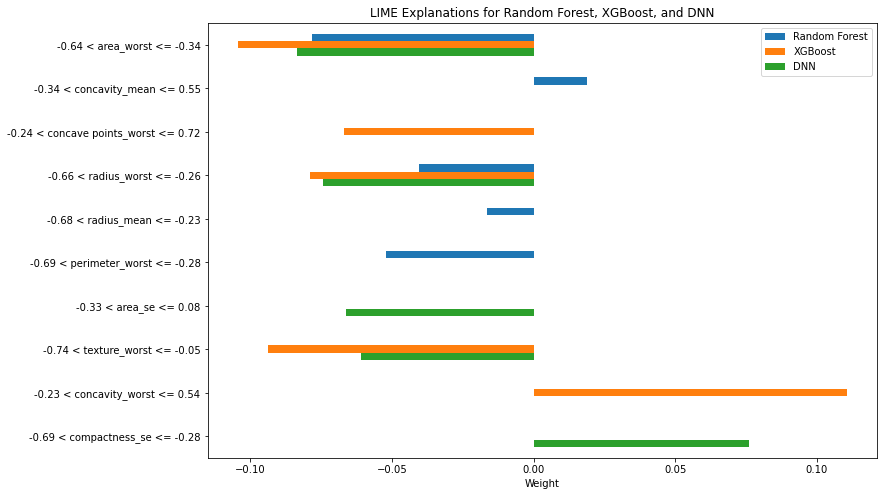

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Benign', 'Malignant'], discretize_continuous=True)

# Function to explain a single instance using LIME
def explain_instance(model, instance, label, is_dnn=False):
    if is_dnn:
        explanation = explainer.explain_instance(instance, lambda x: predict_proba_keras(model, x), num_features=5)
    else:
        explanation = explainer.explain_instance(instance, model.predict_proba, num_features=5)
    print(f"Explanation for {label}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    return explanation

# Function to wrap Keras model predict to mimic predict_proba
def predict_proba_keras(model, instances):
    preds = model.predict(instances)
    return np.hstack((1 - preds, preds))

# Function to plot LIME explanations for all three models
def plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, title):
    features_rf, weights_rf = zip(*rf_explanation.as_list())
    features_xgb, weights_xgb = zip(*xgb_explanation.as_list())
    features_dnn, weights_dnn = zip(*dnn_explanation.as_list())
    
    # Combine all unique features
    all_features = set(features_rf) | set(features_xgb) | set(features_dnn)
    
    # Create a DataFrame for easier plotting
    combined_df = pd.DataFrame(index=all_features, columns=['Random Forest', 'XGBoost', 'DNN'])
    for feature, weight in zip(features_rf, weights_rf):
        combined_df.at[feature, 'Random Forest'] = weight
    for feature, weight in zip(features_xgb, weights_xgb):
        combined_df.at[feature, 'XGBoost'] = weight
    for feature, weight in zip(features_dnn, weights_dnn):
        combined_df.at[feature, 'DNN'] = weight
    
    combined_df = combined_df.fillna(0)
    
    # Plot
    combined_df.plot(kind='barh', figsize=(12, 8))
    plt.xlabel('Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Example instance
instance_index = 0  # Adjust the index as needed
instance = X_test[instance_index]

# Apply LIME to all models for the same instance
print("Random Forest Classifier:")
rf_explanation = explain_instance(rf_model, instance, 'Instance')

print("\nXGBoost Classifier:")
xgb_explanation = explain_instance(xgb_model, instance, 'Instance')

print("\nDeep Neural Networks (DNN):")
dnn_explanation = explain_instance(dnn_model, instance, 'Instance', is_dnn=True)

# Plot combined explanations
plot_combined_explanations(rf_explanation, xgb_explanation, dnn_explanation, 'LIME Explanations for Random Forest, XGBoost, and DNN')



Deep Neural Networks (DNN):
157/157 [==============================] - 0s 1ms/step
Explanation for Instance:
-0.66 < radius_worst <= -0.26: -0.08637167193452454
-0.33 < area_se <= 0.08: -0.08153665027856925
-0.74 < texture_worst <= -0.05: -0.07738095595688321
-0.69 < compactness_se <= -0.28: 0.05629636704801516
-0.69 < perimeter_worst <= -0.28: -0.05428856296721954


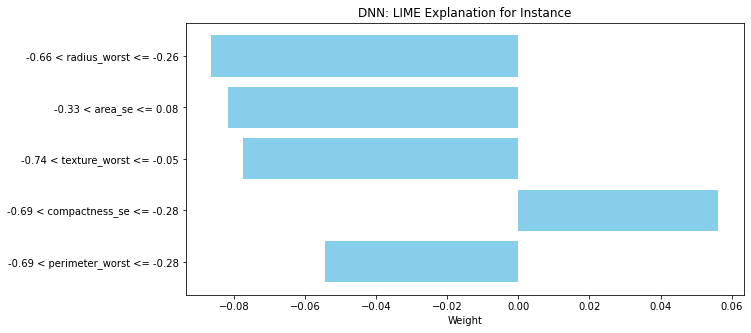

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Benign', 'Malignant'], discretize_continuous=True)

# Function to explain a single instance using LIME
def explain_instance(model, instance, label, is_dnn=False):
    if is_dnn:
        explanation = explainer.explain_instance(instance, lambda x: predict_proba_keras(model, x), num_features=5)
    else:
        explanation = explainer.explain_instance(instance, model.predict_proba, num_features=5)
    print(f"Explanation for {label}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    return explanation

# Function to wrap Keras model predict to mimic predict_proba
def predict_proba_keras(model, instances):
    preds = model.predict(instances)
    return np.hstack((1 - preds, preds))

# Function to plot LIME explanations
def plot_explanation(explanation, title):
    exp = explanation.as_list()
    features, weights = zip(*exp)
    plt.figure(figsize=(10, 5))
    plt.barh(features, weights, color='skyblue')
    plt.xlabel('Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Example instance
instance_index = 0  # Adjust the index as needed
instance = X_test[instance_index]

# Apply LIME to the DNN model for the same instance
print("\nDeep Neural Networks (DNN):")
dnn_explanation = explain_instance(dnn_model, instance, 'Instance', is_dnn=True)

# Plot DNN explanation
plot_explanation(dnn_explanation, 'DNN: LIME Explanation for Instance')


In [22]:
pip install shap


  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Nida\\AppData\\Local\\Temp\\pip-uninstall-4amhcswy\\numpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Initialize SHAP explainer
shap.initjs()

# Function to explain and plot using SHAP
def explain_and_plot_shap(model, X_train, X_test, model_name):
    if isinstance(model, Sequential):
        # Explainer for Deep Neural Networks
        explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train)
    else:
        explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.title(f"SHAP Summary Plot for {model_name}")
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
    plt.show()
    
    # Force plot for a single instance
    instance_index = 0  # Adjust the index as needed
    plt.title(f"SHAP Force Plot for {model_name}")
    shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test[instance_index], feature_names=X.columns, matplotlib=True)
    plt.show()

# Apply SHAP to Random Forest Classifier
print("Random Forest Classifier:")
explain_and_plot_shap(rf_model, X_train, X_test, 'Random Forest')

# Apply SHAP to XGBoost Classifier
print("\nXGBoost Classifier:")
explain_and_plot_shap(xgb_model, X_train, X_test, 'XGBoost')

# Apply SHAP to Deep Neural Networks
print("\nDeep Neural Networks (DNN):")
explain_and_plot_shap(dnn_model, X_train, X_test, 'DNN')


SystemError: initialization of _internal failed without raising an exception

In [24]:
pip install eli5


  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=c016bb7b51dbd3e972a252ce7493badb4037abd59d6de10f8930f7bff0b0eb4f
  Stored in directory: c:\users\nida\appdata\local\pip\cache\wheels\7b\26\a5\8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Apply eli5 to Random Forest Classifier
perm_rf = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm_rf, feature_names=X.columns.tolist())

# Apply eli5 to XGBoost Classifier
perm_xgb = PermutationImportance(xgb_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm_xgb, feature_names=X.columns.tolist())

# For the DNN model, we'll use a wrapper to fit the model with eli5's PermutationImportance
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X).ravel()

dnn_wrapper = KerasWrapper(dnn_model)
perm_dnn = PermutationImportance(dnn_wrapper, random_state=42, scoring='accuracy').fit(X_test, y_test)
eli5.show_weights(perm_dnn, feature_names=X.columns.tolist())


TypeError: estimator should be an estimator implementing 'fit' method, <__main__.KerasWrapper object at 0x0000017FA810C640> was passed

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

# Load the Wisconsin Breast Cancer Dataset
data = pd.read_csv(r'C:\Users\Nida\Downloads\new student\dataset.csv')  # Make sure you have the dataset in the current directory
X = data.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = data['diagnosis'].map({'M': 1, 'B': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the classifiers
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

dnn_model = Sequential()
dnn_model.add(Dense(30, input_dim=30, activation='relu'))
dnn_model.add(Dense(15, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Define a Keras wrapper with fit method
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=10, verbose=0)

    def predict(self, X):
        return self.model.predict(X).ravel()

dnn_wrapper = KerasWrapper(dnn_model)
dnn_wrapper.fit(X_train, y_train)

# Apply eli5 to Random Forest Classifier
perm_rf = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm_rf, feature_names=X.columns.tolist())

# Apply eli5 to XGBoost Classifier
perm_xgb = PermutationImportance(xgb_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm_xgb, feature_names=X.columns.tolist())

# Custom scorer for Keras model
from sklearn.metrics import accuracy_score, make_scorer

def keras_scorer(estimator, X, y):
    return accuracy_score(y, (estimator.predict(X) > 0.5).astype(int))

# Apply eli5 to DNN model
perm_dnn = PermutationImportance(dnn_wrapper, random_state=42, scoring=make_scorer(keras_scorer)).fit(X_test, y_test)
eli5.show_weights(perm_dnn, feature_names=X.columns.tolist())

# Function to plot eli5 importances
def plot_eli5_importances(perm, title):
    weights = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
    plt.figure(figsize=(10, 5))
    plt.barh(weights['feature'], weights['weight'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot Random Forest importances
plot_eli5_importances(perm_rf, 'Random Forest Feature Importances')

# Plot XGBoost importances
plot_eli5_importances(perm_xgb, 'XGBoost Feature Importances')

# Plot DNN importances
plot_eli5_importances(perm_dnn, 'DNN Feature Importances')


4/4 [==============================] - 0s 3ms/step


TypeError: keras_scorer() missing 1 required positional argument: 'y'

In [27]:
graph TD
    A[Start] --> B[Data Collection]
    B --> C[Data Preprocessing]
    C --> D[Splitting Data]
    D --> E[Model Training]
    E --> F1[Random Forest]
    E --> F2[XGBoost]
    E --> F3[Deep Neural Network]
    F1 --> G1[Hyperparameter Tuning]
    F2 --> G2[Hyperparameter Tuning]
    F3 --> G3[Hyperparameter Tuning]
    G1 --> H1[Model Evaluation]
    G2 --> H2[Model Evaluation]
    G3 --> H3[Model Evaluation]
    H1 --> I[Comparison of Models]
    H2 --> I
    H3 --> I
    I --> J[Results and Conclusions]
    J --> K[Future Work]
    K --> L[End]


SyntaxError: invalid syntax (3642813904.py, line 1)

In [28]:
from graphviz import Digraph

In [29]:
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Start')
dot.node('B', 'Data Collection')
dot.node('C', 'Data Preprocessing')
dot.node('D', 'Splitting Data')
dot.node('E', 'Model Training')
dot.node('F1', 'Random Forest')
dot.node('F2', 'XGBoost')
dot.node('F3', 'Deep Neural Network')
dot.node('G1', 'Hyperparameter Tuning')
dot.node('G2', 'Hyperparameter Tuning')
dot.node('G3', 'Hyperparameter Tuning')
dot.node('H1', 'Model Evaluation')
dot.node('H2', 'Model Evaluation')
dot.node('H3', 'Model Evaluation')
dot.node('I', 'Comparison of Models')
dot.node('J', 'Results and Conclusions')
dot.node('K', 'Future Work')
dot.node('L', 'End')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF1', 'EF2', 'EF3', 'F1G1', 'F2G2', 'F3G3', 'G1H1', 'G2H2', 'G3H3', 'H1I', 'H2I', 'H3I', 'IJ', 'JK', 'KL'])

dot.render('flowchart', format='png', view=True)


ValueError: too many values to unpack (expected 2)

In [30]:
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Start')
dot.node('B', 'Data Collection')
dot.node('C', 'Data Preprocessing')
dot.node('D', 'Splitting Data')
dot.node('E', 'Model Training')
dot.node('F1', 'Random Forest')
dot.node('F2', 'XGBoost')
dot.node('F3', 'Deep Neural Network')
dot.node('G1', 'Hyperparameter Tuning')
dot.node('G2', 'Hyperparameter Tuning')
dot.node('G3', 'Hyperparameter Tuning')
dot.node('H1', 'Model Evaluation')
dot.node('H2', 'Model Evaluation')
dot.node('H3', 'Model Evaluation')
dot.node('I', 'Comparison of Models')
dot.node('J', 'Results and Conclusions')
dot.node('K', 'Future Work')
dot.node('L', 'End')

edges = [
    ('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), 
    ('E', 'F1'), ('E', 'F2'), ('E', 'F3'), 
    ('F1', 'G1'), ('F2', 'G2'), ('F3', 'G3'), 
    ('G1', 'H1'), ('G2', 'H2'), ('G3', 'H3'), 
    ('H1', 'I'), ('H2', 'I'), ('H3', 'I'), 
    ('I', 'J'), ('J', 'K'), ('K', 'L')
]

dot.edges(edges)

dot.render('flowchart', format='png', view=True)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [31]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [1]:
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Start')
dot.node('B', 'Data Collection')
dot.node('C', 'Data Preprocessing')
dot.node('D', 'Splitting Data')
dot.node('E', 'Model Training')
dot.node('F1', 'Random Forest')
dot.node('F2', 'XGBoost')
dot.node('F3', 'Deep Neural Network')
dot.node('G1', 'Hyperparameter Tuning')
dot.node('G2', 'Hyperparameter Tuning')
dot.node('G3', 'Hyperparameter Tuning')
dot.node('H1', 'Model Evaluation')
dot.node('H2', 'Model Evaluation')
dot.node('H3', 'Model Evaluation')
dot.node('I', 'Comparison of Models')
dot.node('J', 'Results and Conclusions')
dot.node('K', 'Future Work')
dot.node('L', 'End')

edges = [
    ('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), 
    ('E', 'F1'), ('E', 'F2'), ('E', 'F3'), 
    ('F1', 'G1'), ('F2', 'G2'), ('F3', 'G3'), 
    ('G1', 'H1'), ('G2', 'H2'), ('G3', 'H3'), 
    ('H1', 'I'), ('H2', 'I'), ('H3', 'I'), 
    ('I', 'J'), ('J', 'K'), ('K', 'L')
]

dot.edges(edges)

dot.render('flowchart', format='png', view=True)



ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

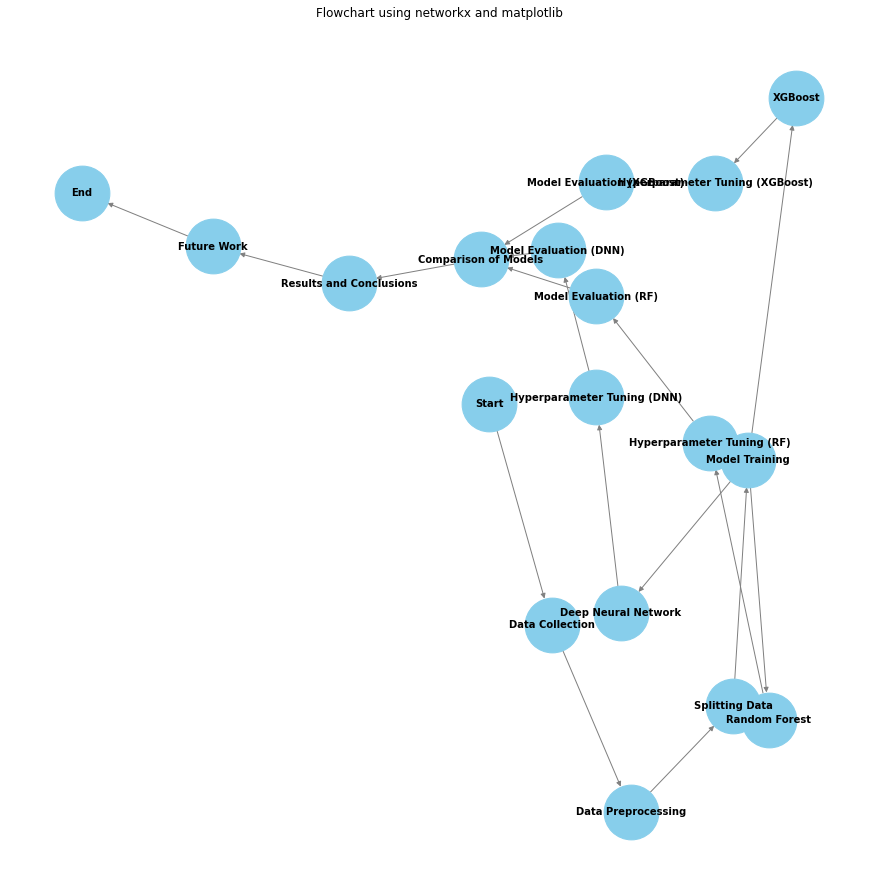

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

edges = [
    ('Start', 'Data Collection'), 
    ('Data Collection', 'Data Preprocessing'), 
    ('Data Preprocessing', 'Splitting Data'), 
    ('Splitting Data', 'Model Training'), 
    ('Model Training', 'Random Forest'), 
    ('Model Training', 'XGBoost'), 
    ('Model Training', 'Deep Neural Network'), 
    ('Random Forest', 'Hyperparameter Tuning (RF)'), 
    ('XGBoost', 'Hyperparameter Tuning (XGBoost)'), 
    ('Deep Neural Network', 'Hyperparameter Tuning (DNN)'), 
    ('Hyperparameter Tuning (RF)', 'Model Evaluation (RF)'), 
    ('Hyperparameter Tuning (XGBoost)', 'Model Evaluation (XGBoost)'), 
    ('Hyperparameter Tuning (DNN)', 'Model Evaluation (DNN)'), 
    ('Model Evaluation (RF)', 'Comparison of Models'), 
    ('Model Evaluation (XGBoost)', 'Comparison of Models'), 
    ('Model Evaluation (DNN)', 'Comparison of Models'), 
    ('Comparison of Models', 'Results and Conclusions'), 
    ('Results and Conclusions', 'Future Work'), 
    ('Future Work', 'End')
]

G.add_edges_from(edges)

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title('Flowchart using networkx and matplotlib')
plt.show()
